# SWCON425 Data Science and Visualization
# Practical Statistics for Data Scientists
## Exploratory Data Analysis (EDA)

Import required Python packages.

In [1]:
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from scipy.stats import trim_mean
from statsmodels import robust
import wquantiles
 
import seaborn as sns
import matplotlib.pylab as plt

Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [2]:
DATA = Path('.').resolve().parents[1] / 'data'

AIRLINE_STATS_CSV = DATA / 'airline_stats.csv'
KC_TAX_CSV = DATA / 'kc_tax.csv.gz'
LC_LOANS_CSV = DATA / 'lc_loans.csv'
AIRPORT_DELAYS_CSV = DATA / 'dfw_airline.csv'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
STATE_CSV = DATA / 'state.csv'

# Estimates of Location


Variables with measured or count data might have thousands of distinct values. A basic step in exploring your data is getting a “typical value” for each feature (variable): an estimate of where most of the data is located (i.e., its central tendency).

## Example: Location Estimates of Population and Murder Rates

In [3]:
# Table below shows the first few rows in the data set containing population and murder rates 
# (in units of murders per 100,000 people per year) for each state.
state = pd.read_csv(STATE_CSV)
print(state.head(10))

         State  Population  Murder.Rate Abbreviation
0      Alabama     4779736          5.7           AL
1       Alaska      710231          5.6           AK
2      Arizona     6392017          4.7           AZ
3     Arkansas     2915918          5.6           AR
4   California    37253956          4.4           CA
5     Colorado     5029196          2.8           CO
6  Connecticut     3574097          2.4           CT
7     Delaware      897934          5.8           DE
8      Florida    18801310          5.8           FL
9      Georgia     9687653          5.7           GA


Compute the mean, trimmed mean, and median for Population. For `mean` and `median` we can use the _pandas_ methods of the data frame. The trimmed mean requires the `trim_mean` function in _scipy.stats_.

In [4]:
state = pd.read_csv(STATE_CSV)
print(state['Population'].mean())

6162876.3


`trim_mean` the average of all values after dropping a fixed number of extreme values at each end.

In [5]:
print(trim_mean(state['Population'], 0.1))

4783697.125


In [6]:
print(state['Population'].median())

4436369.5


Weighted mean is available with numpy. For weighted median, we can use the specialised package `wquantiles` (https://pypi.org/project/wquantiles/).

In [7]:
print(state['Murder.Rate'].mean())

4.066


In [8]:
print(np.average(state['Murder.Rate']))

4.066


In [9]:
print(np.average(state['Murder.Rate'], weights=state['Population']))

4.445833981123393


In [10]:
print(wquantiles.median(state['Murder.Rate'], weights=state['Population']))

4.4


### Key ideas
* **The basic metric for location is the mean, but it can be sensitive to extreme values (outlier).**


* **Other metrics (median, trimmed mean) are more robust.**

# Estimates of Variability

Location is just one dimension in summarizing a feature. A second dimension, *variability*, also referred to as *dispersion*, measures whether the data values are tightly clustered or spread out. At the heart of statistics lies variability: measuring it, reducing it, distinguishing random from real variability, identifying the various sources of real variability, and making decisions in the presence of it.

In [11]:
# Table  
print(state.head(8))

         State  Population  Murder.Rate Abbreviation
0      Alabama     4779736          5.7           AL
1       Alaska      710231          5.6           AK
2      Arizona     6392017          4.7           AZ
3     Arkansas     2915918          5.6           AR
4   California    37253956          4.4           CA
5     Colorado     5029196          2.8           CO
6  Connecticut     3574097          2.4           CT
7     Delaware      897934          5.8           DE


Standard deviation

In [12]:
print(state['Population'].std())

6848235.347401142


Interquartile range (IQR) is calculated as the difference of the 75% and 25% quantile.

In [13]:
print(state['Population'].quantile(0.75) - state['Population'].quantile(0.25))

4847308.0


Median absolute deviation from the median (MAD), the median of the absolute value of the deviations from the median, which can be calculated with a method in _statsmodels_

In [14]:
print(robust.scale.mad(state['Population']))
# print(abs(state['Population'] - state['Population'].median()).median() / 0.6744897501960817)

3849876.1459979336


### Key ideas
* **The variance and standard deviation are the most widespread and routinely reported statistics of variability.**

* **Both are sensitive to outliers.**

* **More robust metrics include mean and median absolute deviations from the mean and percentiles (quantiles).**

# Exploring the Data Distribution

Each of the estimates we’ve covered sums up the data in a single number to describe the location or variability of the data. It is also useful to explore how the
data is distributed overall.

## Percentiles and Boxplots


In “Estimates Based on Variability”, we explored how percentiles can be used to measure the spread of the data. 
Percentiles are also valuable to summarize the entire distribution. 
It is common to report the quartiles (25th, 50th, and 75th percentiles) and the deciles (the 10th, 20th, ..., 90th percentiles). 
Percentiles are especially valuable to summarize the tails (the outer range) of the distribution. 

_Pandas_ has the `quantile` method for data frames.

In [15]:
print(state['Murder.Rate'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64


In [16]:
percentages = [0.05, 0.25, 0.5, 0.75, 0.95]
df = pd.DataFrame(state['Murder.Rate'].quantile(percentages))
df.index = [f'{p * 100}%' for p in percentages]
print(df.transpose())

             5.0%  25.0%  50.0%  75.0%  95.0%
Murder.Rate   1.6  2.425    4.0   5.55   6.51


_Pandas_ provides a number of basic exploratory plots; one of them are boxplots

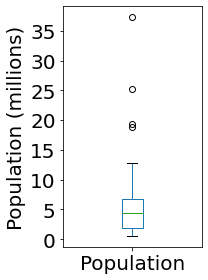

In [17]:
ax = (state['Population']/1_000_000).plot.box(figsize=(3, 4), fontsize = 20)
ax.set_ylabel('Population (millions)', fontsize=20)

plt.tight_layout()
plt.show()

The top and bottom of the box are the 75th and 25th percentiles, respectively. The median is shown by the horizontal line in the box. The dashed lines, referred to as whiskers, extend from the top and bottom to indicate the range for the bulk of the data.

## Frequency Table and Histograms

A frequency table is a tally of the count of numeric data values that fall into a set of intervals (bins).

A frequency table of a variable divides up the variable range into equally spaced segments, and tells us how many values fall in each segment.

The `cut` method for _pandas_ data splits the dataset into bins. There are a number of arguments for the method. The following code creates equal sized bins. The method `value_counts` returns a frequency table.

In [18]:
binnedPopulation = pd.cut(state['Population'], 10)
print(binnedPopulation.value_counts())

(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(15239758.0, 18908791.0]     1
(18908791.0, 22577824.0]     1
(22577824.0, 26246857.0]     1
(33584923.0, 37253956.0]     1
(26246857.0, 29915890.0]     0
(29915890.0, 33584923.0]     0
Name: Population, dtype: int64


In [19]:
binnedPopulation.name = 'binnedPopulation'
df = pd.concat([state, binnedPopulation], axis=1)
df = df.sort_values(by='Population')
df.head(10)
#df.tail(10)

,State,Population,Murder.Rate,Abbreviation,binnedPopulation
49,Wyoming,563626,2.7,WY,"(526935.67, 4232659.0]"
44,Vermont,625741,1.6,VT,"(526935.67, 4232659.0]"
33,North Dakota,672591,3.0,ND,"(526935.67, 4232659.0]"
1,Alaska,710231,5.6,AK,"(526935.67, 4232659.0]"
40,South Dakota,814180,2.3,SD,"(526935.67, 4232659.0]"
7,Delaware,897934,5.8,DE,"(526935.67, 4232659.0]"
25,Montana,989415,3.6,MT,"(526935.67, 4232659.0]"
38,Rhode Island,1052567,2.4,RI,"(526935.67, 4232659.0]"
28,New Hampshire,1316470,0.9,NH,"(526935.67, 4232659.0]"
18,Maine,1328361,1.6,ME,"(526935.67, 4232659.0]"


In [20]:
groups = []
for group, subset in df.groupby(by='binnedPopulation'):
    groups.append({
        'BinRange': group,
        'Count': len(subset),
        'States': ','.join(subset.Abbreviation)
    })
#print(pd.DataFrame(groups))
pd.DataFrame(groups)

,BinRange,Count,States
0,"(526935.67, 4232659.0]",24,"WY,VT,ND,AK,SD,DE,MT,RI,NH,ME,HI,ID,NE,WV,NM,N..."
1,"(4232659.0, 7901692.0]",14,"KY,LA,SC,AL,CO,MN,WI,MD,MO,TN,AZ,IN,MA,WA"
2,"(7901692.0, 11570725.0]",6,"VA,NJ,NC,GA,MI,OH"
3,"(11570725.0, 15239758.0]",2,"PA,IL"
4,"(15239758.0, 18908791.0]",1,FL
5,"(18908791.0, 22577824.0]",1,NY
6,"(22577824.0, 26246857.0]",1,TX
7,"(26246857.0, 29915890.0]",0,
8,"(29915890.0, 33584923.0]",0,
9,"(33584923.0, 37253956.0]",1,CA


- The least populous state is Wyoming, with 563,626 people (2010 Census) and the most populous is California, with 37,253,956 people. 
- This gives us a range of 37,253,956 – 563,626 = 36,690,330, which we must divide up into equal size bins—let’s say 10 bins. 
- With 10 equal size bins, each bin will have a width of 3,669,033, so the first bin will span from 563,626 to 4,232,658. 
- By contrast, the top bin, 33,584,923 to 37,253,956, has only one state: California. 
- The two bins immediately below California are empty, until we reach Texas. 
- It is important to include the empty bins; the fact that there are no values in those bins is useful information. 
- It can also be useful to experiment with different bin sizes. 
- If they are too large, important features of the distribution can be obscured. 
- If they are too small, the result is too granular and the ability to see bigger pictures is lost.

_Pandas_ also supports histograms for exploratory data analysis.

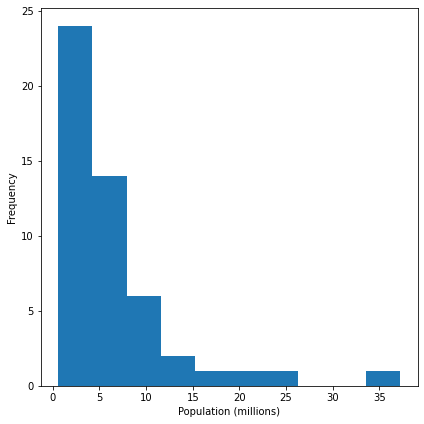

In [21]:
ax = (state['Population'] / 1_000_000).plot.hist(figsize=(6, 6))
ax.set_xlabel('Population (millions)')

plt.tight_layout()
plt.show()

## Density Estimates

Related to the histogram is a density plot, which shows the distribution of data values as a continuous line. A density plot can be thought of as a smoothed histogram, although it is typically computed directly from the data through a *kernal density estimate*. 

Density is an alternative to histograms that can provide more insight into the distribution of the data points. Use the argument `bw_method` to control the smoothness of the density curve.

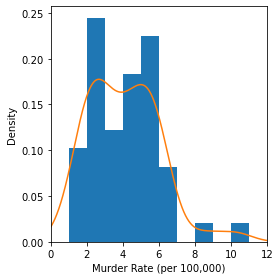

In [22]:
ax = state['Murder.Rate'].plot.hist(density=True, xlim=[0, 12], 
                                    bins=range(1,12), figsize=(4, 4))
state['Murder.Rate'].plot.density(ax=ax) # experiment with bw_method

ax.set_xlabel('Murder Rate (per 100,000)')

plt.tight_layout()
plt.show()

#### Key ideas
* **A frequency histogram plots frequency counts on the y-axis and variable values on the x-axis; it gives a sense of the distribution of the data at a glance.**

* **A frequency table is a tabular version of the frequency counts found in a histogram.**

* **A boxplot—with the top and bottom of the box at the 75th and 25th percentiles, respectively—also gives a quick sense of the distribution of the data; it is often used in side-by-side displays to compare distributions.**

* **A density plot is a smoothed version of a histogram; it requires a function to estimate a plot based on the data (multiple estimates are possible, of course).**

# Exploring Binary and Categorical Data

For categorical data, simple proportions or percentages tell the story of the data.

In [23]:
# Table below shows counts of delays by cause at Dallas-Fort Worth airport 
dfw = pd.read_csv(AIRPORT_DELAYS_CSV)
dfw
# ATC = Air Traffic Control

,Carrier,ATC,Weather,Security,Inbound
0,64263.16,84856.5,11235.42,343.15,118427.82


In [24]:
# Table below shows percentage of delays by cause at Dallas-Fort Worth airport 
#dfw_per = 100 * dfw / dfw.values.sum()
print(100 * dfw / dfw.values.sum())

     Carrier        ATC   Weather  Security    Inbound
0  23.022989  30.400781  4.025214  0.122937  42.428079


_Pandas_ also supports bar charts for displaying a single categorical variable.

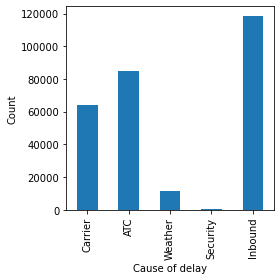

In [25]:
ax = dfw.transpose().plot.bar(figsize=(4, 4), legend=False)
#ax = dfw_per.transpose().plot.bar(figsize=(4, 4), legend=False)

ax.set_xlabel('Cause of delay')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

Bar charts are a common visual tool for displaying a single categorical variable, often seen in the popular press. 

Categories are listed on the x-axis, and frequencies or proportions on the y-axis.

Note that a bar chart resembles a histogram; in a bar chart the x-axis represents different categories of a factor variable, while in a histogram the x-axis represents values of a single variable on a numeric scale. 

In a histogram, the bars are typically shown touching each other, with gaps indicating values that did not occur in the data. 

In a bar chart, the bars are shown separate from one another.

#### Key ideas
* **Categorical data is typically summed up in proportions, and can be visualized in a bar chart.**

* **Categories might represent distinct things (apples and oranges, male and female), levels of a factor variable (low, medium, and high), or numeric data that has been binned.**

# Correlation

Exploratory data analysis in many modeling projects (whether in data science or in research) involves examining correlation among predictors, and between predictors and a target variable. 

Variables X and Y (each with measured data) are said to be positively correlated if high values of X go with high values of Y, and low values of X go with low values of Y. 

If high values of X go with low values of Y, and vice versa, the variables are negatively correlated.

* **Correlation coefficient**: A metric that measures the extent to which numeric variables are associated with one another (ranges from –1 to +1).
* **Correlation matrix**: A table where the variables are shown on both rows and columns, and the cell values are the correlations between the variables.
* **Scatter plot**: A plot in which the x-axis is the value of one variable, and the y-axis the value of another.

First read the required datasets (telecommunications)

In [26]:
sp500_sym = pd.read_csv(SP500_SECTORS_CSV)
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)

In [27]:
# Table 1-7
# Determine telecommunications symbols
telecomSymbols = sp500_sym[sp500_sym['sector'] == 'telecommunications_services']['symbol']
telecomSymbols
# ATT (T), Verizon (VZ), 
# Level Three (LVLT) - infrastructure company

332       T
333     CTL
334     FTR
335      VZ
336    LVLT
Name: symbol, dtype: object

In [28]:
# Filter data for dates July 2012 through June 2015
telecom = sp500_px.loc[sp500_px.index >= '2012-07-01', telecomSymbols]
telecom

,T,CTL,FTR,VZ,LVLT
2012-07-02,0.422496,0.140847,0.070879,0.554180,-0.519998
2012-07-03,-0.177448,0.066280,0.070879,-0.025976,-0.049999
2012-07-05,-0.160548,-0.132563,0.055128,-0.051956,-0.180000
2012-07-06,0.342205,0.132563,0.007875,0.140106,-0.359999
2012-07-09,0.136883,0.124279,-0.023626,0.253943,0.180000
...,...,...,...,...,...
2015-06-25,0.049342,-1.600000,-0.040000,-0.187790,-0.330002
2015-06-26,-0.256586,0.039999,-0.070000,0.029650,-0.739998
2015-06-29,-0.098685,-0.559999,-0.060000,-0.504063,-1.360000
2015-06-30,-0.503298,-0.420000,-0.070000,-0.523829,0.199997


In [29]:
# Correlation coefficient
telecom.corr()
#print(telecom.corr())
#print(telecom)

,T,CTL,FTR,VZ,LVLT
T,1.000000,0.474683,0.327767,0.677612,0.278626
CTL,0.474683,1.000000,0.419757,0.416604,0.286665
FTR,0.327767,0.419757,1.000000,0.287386,0.260068
VZ,0.677612,0.416604,0.287386,1.000000,0.242199
LVLT,0.278626,0.286665,0.260068,0.242199,1.000000


Note the diagonal of 1s (the correlation of a stock with itself is 1), and the redundancy of the information above and below the diagonal.

Next we focus on funds traded on major exchanges (sector == 'etf'). **ETF = exchange traded funds**

In [30]:
etfs = sp500_px.loc[sp500_px.index > '2012-07-01', 
                    sp500_sym[sp500_sym['sector'] == 'etf']['symbol']]
#print(etfs.head())
etfs.head()

,XLI,QQQ,SPY,DIA,GLD,VXX,USO,IWM,XLE,XLY,XLU,XLB,XTL,XLV,XLP,XLF,XLK
2012-07-02,-0.376098,0.096313,0.028223,-0.242796,0.419998,-10.40,0.000000,0.534641,0.028186,0.095759,0.098311,-0.093713,0.019076,-0.009529,0.313499,0.018999,0.075668
2012-07-03,0.376099,0.481576,0.874936,0.728405,0.490006,-3.52,0.250000,0.926067,0.995942,0.000000,-0.044686,0.337373,0.000000,0.000000,0.129087,0.104492,0.236462
2012-07-05,0.150440,0.096313,-0.103487,0.149420,0.239991,6.56,-0.070000,-0.171848,-0.460387,0.306431,-0.151938,0.103086,0.019072,-0.142955,-0.073766,-0.142490,0.066211
2012-07-06,-0.141040,-0.491201,0.018819,-0.205449,-0.519989,-8.80,-0.180000,-0.229128,0.206706,0.153214,0.080437,0.018744,-0.429213,-0.095304,0.119865,0.066495,-0.227003
2012-07-09,0.244465,-0.048160,-0.056445,-0.168094,0.429992,-0.48,0.459999,-0.190939,-0.234892,-0.201098,-0.035751,-0.168687,0.000000,0.352630,-0.064548,0.018999,0.009457


In [31]:
etfs.corr()

,XLI,QQQ,SPY,DIA,GLD,VXX,USO,IWM,XLE,XLY,XLU,XLB,XTL,XLV,XLP,XLF,XLK
XLI,1.000000,0.785865,0.888865,0.869680,0.056554,-0.468196,0.236881,0.782380,0.650054,0.798080,0.380809,0.784144,0.374000,0.663022,0.600424,0.787340,0.777773
QQQ,0.785865,1.000000,0.908995,0.834440,0.043553,-0.470555,0.199492,0.810158,0.560044,0.839701,0.346667,0.713463,0.421790,0.775392,0.614806,0.752771,0.945126
SPY,0.888865,0.908995,1.000000,0.953726,0.078722,-0.547074,0.272069,0.833937,0.713300,0.887028,0.481928,0.826053,0.406181,0.811269,0.744466,0.883616,0.886588
DIA,0.869680,0.834440,0.953726,1.000000,0.051523,-0.511327,0.256793,0.758012,0.658311,0.847043,0.463364,0.787415,0.383928,0.771044,0.753725,0.860556,0.842757
GLD,0.056554,0.043553,0.078722,0.051523,1.000000,-0.107488,0.216563,0.070110,0.188625,0.017467,0.121611,0.184366,-0.042233,-0.010200,0.033047,0.043039,0.053022
VXX,-0.468196,-0.470555,-0.547074,-0.511327,-0.107488,1.000000,-0.195397,-0.448942,-0.448474,-0.474756,-0.260395,-0.470890,-0.205661,-0.380925,-0.416913,-0.514365,-0.477258
USO,0.236881,0.199492,0.272069,0.256793,0.216563,-0.195397,1.000000,0.249799,0.525943,0.183275,0.113182,0.324166,0.078796,0.119500,0.116857,0.221760,0.225962
IWM,0.782380,0.810158,0.833937,0.758012,0.070110,-0.448942,0.249799,1.000000,0.586991,0.779750,0.325003,0.701533,0.387274,0.664288,0.537065,0.756282,0.760438
XLE,0.650054,0.560044,0.713300,0.658311,0.188625,-0.448474,0.525943,0.586991,1.000000,0.578956,0.337942,0.689778,0.260463,0.454457,0.413486,0.599129,0.559324
XLY,0.798080,0.839701,0.887028,0.847043,0.017467,-0.474756,0.183275,0.779750,0.578956,1.000000,0.366827,0.721232,0.370299,0.702860,0.663055,0.782053,0.772189


Due to the large number of columns in this table, looking at the correlation matrix is cumbersome and it's more convenient to plot the correlation as a heatmap. The _seaborn_ package provides a convenient implementation for heatmaps.

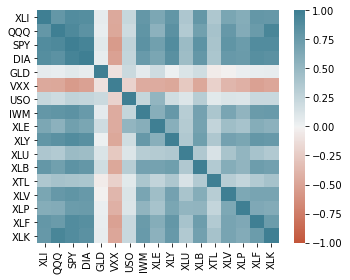

In [32]:
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.heatmap(etfs.corr(), vmin=-1, vmax=1, 
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 ax=ax)

plt.tight_layout()
plt.show()

The ETFs for the S&P 500 (SPY) and the Dow Jones Index (DIA) have a high correlation. 

Similary, the QQQ and the XLK, composed mostly of technology companies, are postively correlated. 

Defensive ETFs, such as those tracking gold prices (GLD) or market volatility (VXX) tend to be negatively correlated with the other ETFs.

The above heatmap works when you have color. For the greyscale images, we need to visualize the direction as well. The following code shows the strength of the correlation using ellipses.

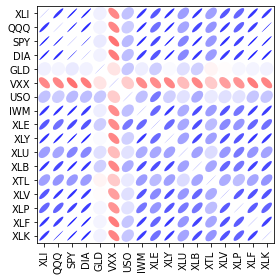

In [33]:
from matplotlib.collections import EllipseCollection
from matplotlib.colors import Normalize

def plot_corr_ellipses(data, figsize=None, **kwargs):
    ''' https://stackoverflow.com/a/34558488 '''
    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    fig, ax = plt.subplots(1, 1, figsize=figsize, subplot_kw={'aspect':'equal'})
    ax.set_xlim(-0.5, M.shape[1] - 0.5)
    ax.set_ylim(-0.5, M.shape[0] - 0.5)
    ax.invert_yaxis()

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel() + 0.01
    h = 1 - np.abs(M).ravel() - 0.01
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           norm=Normalize(vmin=-1, vmax=1),
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec

m = plot_corr_ellipses(etfs.corr(), figsize=(5, 4), cmap='bwr_r')
cb = fig.colorbar(m)
cb.set_label('Correlation coefficient')

plt.tight_layout()
plt.show()

The orientation of the ellipse indicates whether two variables are positively correlated (ellipse is pointed right) or negatively correlated (ellipse is pointed left). The shading and width of the ellipse indicate the strength of the association: thinner and darker ellipses correspond to stronger relationships.

Note that like the mean and standard deviation, the correlation coefficient is sensitive to outliers in the data

## Scatterplots

The standard way to visualize the relationship between two measured data variables is with a scatterplot. 

The x-axis represents one variable, the y-axis another, and each point on the graph is a record.

Simple scatterplots are supported by _pandas_. Specifying the marker as `$\u25EF$` uses an open circle for each point.

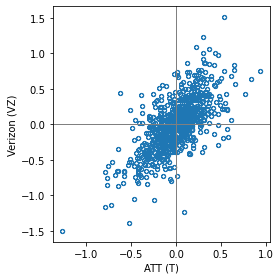

In [34]:
ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4, 4), marker='$\u25EF$')
#ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4, 4), marker='s')
#ax = telecom.plot.scatter(x='T', y='VZ', figsize=(4, 4), marker='$\u25EF$', alpha=0.5)
ax.set_xlabel('ATT (T)')
ax.set_ylabel('Verizon (VZ)')
ax.axhline(0, color='grey', lw=1)
ax.axvline(0, color='grey', lw=1)

plt.tight_layout()
plt.show()

### Key ideas
* **The correlation coefficient measures the extent to which two variables are associated with one another.**

* **When high values of v1 go with high values of v2, v1 and v2 are positively associated.**


* **When high values of v1 are associated with low values of v2, v1 and v2 are negatively associated.**


* **The correlation coefficient is a standardized metric so that it always ranges from –1 (perfect negative correlation) to +1 (perfect positive correlation).**

# Exploring Two or More Variables

Familiar estimators like mean and variance look at variables one at a time (univariate analysis). Correlation analysis (see “Correlation”) is an important method that compares two variables (bivariate analysis). 

In this part, we look at additional estimates and plots, and at more than two variables (*multivariate analysis*)

Like univariate analysis, bivariate analysis involves both computing summary statistics and producing visual displays. The appropriate type of bivariate or multivariate analysis depends on the nature of the data: numeric versus categorical.

Load the kc_tax dataset and filter based on a variety of criteria

In [35]:
# kc_tax contains the tax-assessed values for residiential properties in King County, Washington. 
kc_tax = pd.read_csv(KC_TAX_CSV)
#print(kc_tax.head(10))
kc_tax.head(10)

,TaxAssessedValue,SqFtTotLiving,ZipCode
0,NaN,1730,98117.0
1,206000.0,1870,98002.0
2,303000.0,1530,98166.0
3,361000.0,2000,98108.0
4,459000.0,3150,98108.0
5,223000.0,1570,98032.0
6,259000.0,1770,98168.0
7,175000.0,1150,98168.0
8,178000.0,1980,98168.0
9,186000.0,1490,98168.0


In [36]:
# In order to focus on the main part of the data, we strip out very expensive and very small or large residences:
kc_tax0 = kc_tax.loc[(kc_tax.TaxAssessedValue < 750000) & 
                     (kc_tax.SqFtTotLiving > 100) &
                     (kc_tax.SqFtTotLiving < 3500), :]
print(kc_tax0.shape)
kc_tax0

(432693, 3)


,TaxAssessedValue,SqFtTotLiving,ZipCode
1,206000.0,1870,98002.0
2,303000.0,1530,98166.0
3,361000.0,2000,98108.0
4,459000.0,3150,98108.0
5,223000.0,1570,98032.0
...,...,...,...
498244,375000.0,2230,98056.0
498245,316000.0,1710,98056.0
498246,340000.0,1930,98056.0
498247,132000.0,2930,98056.0


## Hexagonal binning and Contours 
### Plotting numeric versus numeric data

Scatterplots are fine when there is a relatively small number of data values. 

For data sets with hundreds of thousands or millions of records, a scatterplot will be too dense, so we need a different way to visualize the relationship. 

If the number of data points gets large, scatter plots will no longer be meaningful. 

Here methods that visualize densities are more useful. The `hexbin` method for _pandas_ data frames is one powerful approach.

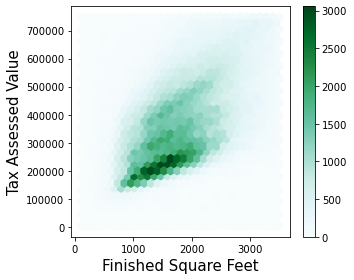

In [37]:
ax = kc_tax0.plot.hexbin(x='SqFtTotLiving', y='TaxAssessedValue',
                         gridsize=30, sharex=False, figsize=(5, 4))
ax.set_xlabel('Finished Square Feet', fontsize = 15)
ax.set_ylabel('Tax Assessed Value', fontsize = 15)

plt.tight_layout()
plt.show()

*hexagon binning* plot of the relationship between the finished square feet versus the tax-assessed value for homes in King County. 

Rather than plotting points, which would appear as a monolithic dark cloud, we grouped the records into hexagonal bins and plotted the hexagons with a color indicating the number of records in that bin. 

In this chart, the positive relationship between square feet and tax-assessed value is clear. 

An interesting feature is the hint of a second cloud above the main cloud, indicating homes that have the same square footage as those in the main cloud, but a higher tax-assessed value.

The _seaborn_ kdeplot is a two-dimensional extension of the density plot. Don't run this cell during lecture as it takes a while to plot the kdeplot with two variables.

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


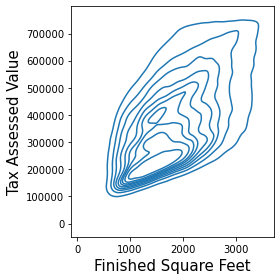

In [38]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.kdeplot(kc_tax0.SqFtTotLiving, kc_tax0.TaxAssessedValue, ax=ax)
ax.set_xlabel('Finished Square Feet', fontsize = 15)
ax.set_ylabel('Tax Assessed Value', fontsize = 15)

plt.tight_layout()
plt.show()

## Two Categorical Variables

A useful way to summarize two categorical variables is a contingency table—a table of counts by category. 


Load the `lc_loans` dataset.

In [39]:
lc_loans = pd.read_csv(LC_LOANS_CSV)
lc_loans.head(10)
lc_loans

,status,grade
0,Fully Paid,B
1,Charged Off,C
2,Fully Paid,C
3,Fully Paid,C
4,Current,B
...,...,...
450956,Current,D
450957,Current,D
450958,Current,D
450959,Current,D


A useful way to summarize two categorical variables is a contingency table — a table of counts by category. Table below shows the contingency table between the grade of a personal loan and the outcome of that loan. The grade goes from A (high) to G (low). The outcome is either paid off, current, late, or charged off (the balance of the loan is not expected to be collected). This table shows the count and raw percentages. 

In [40]:
# Table 
crosstab = lc_loans.pivot_table(index='grade', columns='status', 
                                aggfunc=lambda x: len(x), margins=True)
#print(crosstab)
crosstab

status,Charged Off,Current,Fully Paid,Late,All
grade,,,,,
A,1562,50051,20408,469,72490
B,5302,93852,31160,2056,132370
C,6023,88928,23147,2777,120875
D,5007,53281,13681,2308,74277
E,2842,24639,5949,1374,34804
F,1526,8444,2328,606,12904
G,409,1990,643,199,3241
All,22671,321185,97316,9789,450961


High-grade loans have a very low late/charge-off percentage as compared with lower-grade loans. Contingency tables can look at just counts, or also include column and total percentages. 

In [41]:
# Table
df = crosstab.copy().loc['A':'G',:]
df.loc[:,'Charged Off':'Late'] = df.loc[:,'Charged Off':'Late'].div(df['All'], axis=0)
df['All'] = df['All'] / sum(df['All'])
perc_crosstab = df
#print(perc_crosstab)
perc_crosstab

status,Charged Off,Current,Fully Paid,Late,All
grade,,,,,
A,0.021548,0.690454,0.281528,0.006470,0.160746
B,0.040054,0.709013,0.235401,0.015532,0.293529
C,0.049828,0.735702,0.191495,0.022974,0.268039
D,0.067410,0.717328,0.184189,0.031073,0.164708
E,0.081657,0.707936,0.170929,0.039478,0.077177
F,0.118258,0.654371,0.180409,0.046962,0.028614
G,0.126196,0.614008,0.198396,0.061401,0.007187


## Categorical and Numeric Data

Boxplots (see “Percentiles and Boxplots”) are a simple way to visually compare the distributions of a numeric variable grouped according to a categorical variable. For example, we might want to compare how the percentage of flight delays varies across airlines. Figure below shows the percentage of flights in a month that were delayed where the delay was within the carrier’s control.

_Pandas_ boxplots of a column can be grouped by a different column.

In [42]:
airline_stats = pd.read_csv(AIRLINE_STATS_CSV)
airline_stats.head()

,pct_carrier_delay,pct_atc_delay,pct_weather_delay,airline
0,8.153226,1.971774,0.762097,American
1,5.959924,3.706107,1.585878,American
2,7.157270,2.706231,2.026706,American
3,12.100000,11.033333,0.000000,American
4,7.333333,3.365591,1.774194,American


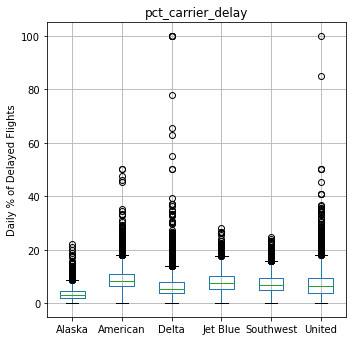

In [43]:
ax = airline_stats.boxplot(by='airline', column='pct_carrier_delay',
                           figsize=(5, 5))
ax.set_xlabel('')
ax.set_ylabel('Daily % of Delayed Flights')
plt.suptitle('')

plt.tight_layout()
plt.show()

Alaska stands out as having the fewest delays, while American has the most delays: the lower quartile for American is higher than the upper quartile for Alaska.

A *violin plot* is an enhancement to the boxplot and plots the density estimate with the density on the y-axis. 

The density is mirrored and flipped over and the resulting shape is filled in, creating an image resembling a violin. 

The advantage of a violin plot is that it can show nuances in the distribution that aren’t perceptible in a boxplot. 

On the other hand, the boxplot more clearly shows the outliers in the data

_Pandas_ also supports a variation of boxplots called _violinplot_. 

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


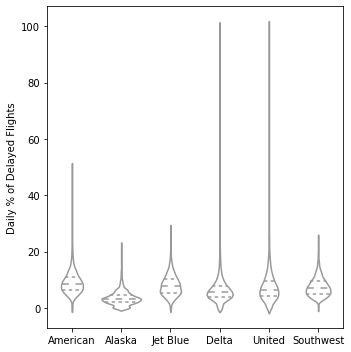

In [44]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.violinplot(airline_stats.airline, airline_stats.pct_carrier_delay,
               ax=ax, inner='quartile', color='white')
ax.set_xlabel('')
ax.set_ylabel('Daily % of Delayed Flights')

plt.tight_layout()
plt.show()

The violin plot shows a concentration in the distribution near zero for Alaska, and to a lesser extent, Delta. This phenomenon is not as obvious in the boxplot.

## Visualizing Multiple Variables

The types of charts used to compare two variables—scatterplots, hexagonal binning, and boxplots—are readily extended to more variables through the notion of *conditioning*.

In [45]:
zip_codes = [98188, 98105, 98108, 98126]
kc_tax_zip = kc_tax0.loc[kc_tax0.ZipCode.isin(zip_codes),:]
kc_tax_zip

,TaxAssessedValue,SqFtTotLiving,ZipCode
3,361000.0,2000,98108.0
4,459000.0,3150,98108.0
10,202000.0,830,98108.0
11,210000.0,1130,98108.0
12,193000.0,1560,98108.0
...,...,...,...
498049,346000.0,1430,98105.0
498050,463000.0,1610,98105.0
498051,553000.0,1580,98105.0
498052,571000.0,1840,98105.0


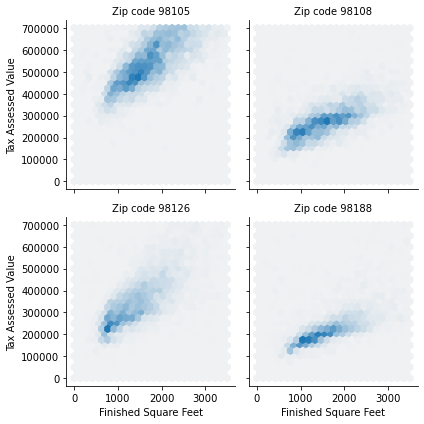

In [46]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=25, cmap=cmap, **kwargs)

g = sns.FacetGrid(kc_tax_zip, col='ZipCode', col_wrap=2)
g.map(hexbin, 'SqFtTotLiving', 'TaxAssessedValue', 
      extent=[0, 3500, 0, 700000])
g.set_axis_labels('Finished Square Feet', 'Tax Assessed Value')
g.set_titles('Zip code {col_name:.0f}')

plt.tight_layout()
plt.show()

This figure accounts for the effect of location by plotting the data for a set of zip codes. Now the picture is much clearer: tax-assessed value is much higher in some zip codes (98126, 98105) than in others (98108, 98188). 